
# Landlab Landslide Probability Model with Saturation 

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:200px;padding:20px">   


<br />
This Jupyter Notebook runs the Landlab LandslideProbability component on a synthetic 
Landlab grid using four depth to water table options to replace recharge options described in the paper: <br />
#### Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br /> 
This notebook performs the following functions:<br >
* Import libraries and set HydroShare variables<br />
* Create a grid and data fields used to calculate landslide probability<br />
* Specify Depth to Water Table Distributions to compare four options<br /> 
* Run LandslideProbability function from Landlab landslide component<br /> 
* Compare the sensitivity based on four Depth to Water Table options<br /> 



## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

In [1]:
#import Python utilities for calculating and plotting
import six
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import warnings
print('Ignore deprecation warnings')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

#import utilities for importing and exporting to HydroShare
from utilities import hydroshare
# set variables for interacting with HydroShare from this notebook
hs=hydroshare.hydroshare()
# Create object to map the home directory
hs=hydroshare.hydroshare()
homedir = os.getcwd()
print('Data will be loaded from and saved to:'+homedir)
os.chdir('/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents')
print(homedir)

# Import Landlab libraries
import landslide_probability
from landslide_probability_20191202 import LandslideProbability
from landlab import RasterModelGrid
from landlab import imshow_grid_at_node

from landlab.io.netcdf import read_netcdf
from landlab.io.netcdf import write_netcdf

import numpy as np
import xarray as xr
import pandas as pd

from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii

Ignore deprecation warnings
Successfully established a connection with HydroShare
Successfully established a connection with HydroShare
Data will be loaded from and saved to:/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents
/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents
You are not going crazy...


/opt/conda/envs/python2/lib/python2.7/site-packages/landlab/__init__.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/kernelapp.py",

You are not going crazy...


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

This example uses a synthetic model domain. As a first example, make a synthetic grid with 5 rows and 4 columns space 0.2 units apart.   <br /> 
##### Synthetic Grid Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the rows, columns, and spacing of your choice.  

In [2]:
grid = read_netcdf('synthetic_data_driven_spatial_depth.nc')

In [3]:
grid.at_node.keys()

['YR1', 'YR2', 'YR3']

Confirm the size of the grid

In [4]:
grid.number_of_nodes

20

To see what the grid id of our nodes are, execute the command below.  However, note that this command gives you the rows of the grid, but these are technically up-side-down from how the RasterModelGrid nodes are numbered (e.g,. node id 0 is at the bottom left corner of the grid). 

In [5]:
grid.nodes

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

We can also see how many core nodes we have (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'. Compare this array to the full grid above.  Asign these to the variable 'core_nodes' so we can use these later.

In [6]:
core_nodes = grid.core_nodes
core_nodes

array([ 5,  6,  9, 10, 13, 14])

Now we will create the required fields for the landslide component and add data as fields to the grid.  Thus, the data arrays will need to be as the length of the number of nodes.<br /> 
##### Data Fields Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the data inputs of your choice.  

In [7]:
gridnodes = grid.number_of_nodes
grid_size = grid.number_of_nodes

grid['node']['soil__density']= \
         2000. * np.ones(gridnodes)

grid['node']['soil__internal_friction_angle']= \
         np.sort(np.random.randint(26, 37, gridnodes))

grid['node']['soil__mode_total_cohesion']= \
         np.sort(np.random.randint(30, 900, gridnodes))
    
scatter_dat = np.random.randint(1, 10, gridnodes)    
grid['node']['soil__maximum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] + scatter_dat

grid['node']['soil__minimum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] - scatter_dat

grid['node']['soil__thickness']= \
         np.sort(np.random.randint(1, 10, gridnodes))

grid['node']['soil__transmissivity']= \
         np.sort(np.random.randint(5, 20, gridnodes),-1)
        
grid['node']['topographic__slope'] = np.random.rand(gridnodes)

grid['node']['topographic__specific_contributing_area']= \
         np.sort(np.random.randint(30, 900, gridnodes))

Let's see what one of these fields (slope) looks like on the grid.

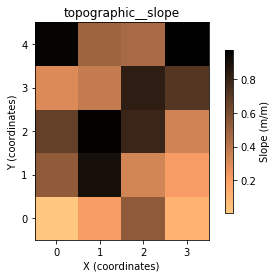

In [8]:
plt.figure('Slope')
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
plt.savefig('Slope.png')

In [9]:
np.mean(grid['node']['soil__thickness'])

4.0999999999999996

In [10]:
key=np.arange(grid.number_of_nodes)
HSD_dict_annualmaxDWT=zip(grid['node']['YR1'],grid['node']['YR2'],grid['node']['YR3'])
#i=1
for i in range(grid.number_of_nodes):
    HSD_dict_annualmaxDWT[i] = {key[i]:HSD_dict_annualmaxDWT[i]} 

print(HSD_dict_annualmaxDWT)

hwdist=pd.DataFrame.from_dict(HSD_dict_annualmaxDWT[i], orient='index')
print(hwdist.values[0])

[{0: (3.1348855160345486, 2.1339028896492409, 4.2298493546765314)}, {1: (4.3641055473531214, 3.3839620238107222, 4.4822002297488588)}, {2: (4.9997363861010431, 4.4987411920372287, 3.8892047488581669)}, {3: (3.9480286943080589, 2.007680398674899, 4.3143715531551994)}, {4: (3.8487040702022735, 2.48373836203718, 2.3989945374607911)}, {5: (4.176460110679832, 2.3597464046292518, 3.86995565015072)}, {6: (3.9938494706376044, 4.9504547555157892, 3.1362133315826775)}, {7: (4.2026147447657127, 4.8803142543445528, 2.9848784481643795)}, {8: (4.1163454826398613, 3.746951123011975, 2.1198065039185501)}, {9: (4.6215269665299221, 2.7099028438244708, 4.829102153571891)}, {10: (3.7740425056733122, 2.0782994936051171, 3.8324204869673371)}, {11: (2.7359464420021391, 2.8233773035209206, 4.8240207409403384)}, {12: (4.9040529801858987, 4.7971356536503436, 2.6893029622097657)}, {13: (2.0149565917571559, 3.5470104394242314, 2.7042667872425739)}, {14: (3.4423020872620453, 3.7744471204150347, 2.0271274892017592)

In [11]:
grid['node']['soil__thickness']

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 5, 6, 6, 7, 8, 8, 8, 9])

In [12]:

n=50

distribution1 = 'data_driven_spatial'


LS_prob1=LandslideProbability(grid, number_of_iterations=n,
                     groundwater__depth_distribution='data_driven_spatial',
                     groundwater__depth_HSD_inputs=[HSD_dict_annualmaxDWT])




Input read for groundwater__recharge_distribution
None
Input read for  groundwater__depth_distribution
data_driven_spatial


In [13]:
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.constants
from scipy import interpolate

Yrand = np.sort(np.random.rand(n))
Fx = ECDF(hwdist.values[0])
Fx_ = Fx(hwdist.values[0])
print(Fx_)
f = interpolate.interp1d(Fx_, hwdist.values[0], bounds_error=False,
                                     fill_value=min(hwdist.values[0]))

De_interpolated = f(Yrand)
print('Input Depth Annual Year Max Data = 3 years')
print(hwdist.values[0])
print('Input Depth Annual Year Max Interpolated Data = n years')
print(De_interpolated)

[ 0.66666667  1.          0.33333333]
Input Depth Annual Year Max Data = 3 years
[ 2.64262339  2.83152669  2.54529527]
Input Depth Annual Year Max Interpolated Data = n years
[ 2.54529527  2.54529527  2.54529527  2.54529527  2.54529527  2.54529527
  2.54529527  2.54529527  2.54529527  2.54529527  2.54529527  2.55293784
  2.55416501  2.55992608  2.56904195  2.57166773  2.57557365  2.57573577
  2.58115591  2.58271191  2.6003387   2.60239619  2.60706452  2.60821211
  2.61382728  2.61394097  2.62396463  2.62668953  2.62810223  2.62830705
  2.63481408  2.63655813  2.64268009  2.64487391  2.6512111   2.66017129
  2.67012168  2.70358269  2.70580592  2.7071504   2.71349521  2.71770786
  2.7366707   2.75786129  2.77019338  2.78936157  2.79964817  2.80017002
  2.81093402  2.8194095 ]


### Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety values using a Monte Carlo simulation approach, which randomly selects input values from parameter distributions. You can pick the number of iterations to run Monte Carlo simulations, but the default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure result becomes.<br /> 
##### Random iterations Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the number of iterations of your choice.  

## Specify Lognormal Spatial Depth to Water Table Recharge Distribution

There are _four_ different options for providing recharge for the Monte Carlo simulation.  We'll provide each of these recharge options below by specifying a recharge distribution and the necessary parameters. <br /> 
##### Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cells below to adjust the recharge distributions.

 ### 1. Saturation Option - 'lognormal_spatial' distribution 
 
In this option, we'll apply a uniform distribution of recharge based on minimum and maximum recharge values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and instantiating the component.

## Run the Landslide Component 

In [14]:
LS_prob1.calculate_landslide_probability()
print('Landslide probability successfully calculated')

In calculate HSD loop - _hwdist.values[0]
[ 4.17646011  2.3597464   3.86995565]
[ 1.          0.33333333  0.66666667]
Input Depth Annual Year Max Data = 3 years
[ 4.17646011  2.3597464   3.86995565]
Input Depth Annual Year Max Interpolated Data = n years
[ 2.3597464   2.3597464   2.3597464   2.3597464   2.3597464   2.3597464
  2.3597464   2.3597464   2.3597464   2.3597464   2.3597464   2.3597464
  2.3597464   2.3597464   2.3597464   2.3597464   2.3597464   2.3597464
  2.3597464   2.3597464   2.3597464   2.3597464   2.3597464   2.3597464
  2.3597464   2.3597464   2.52009364  2.72640857  2.83667734  2.96221768
  2.97282129  3.2201793   3.41659742  3.43288646  3.45893633  3.50680893
  3.58986705  3.80852785  3.8231222   3.8706395   3.89368411  3.91561918
  3.93670948  4.01186099  4.01916818  4.02744828  4.11144702  4.15481427
  4.15509162  4.1657697 ]
In calculate HSD loop -interpolate _hwdist.values[0]
[ 2.3597464   2.3597464   2.3597464   2.3597464   2.3597464   2.3597464
  2.3597464   

[ 0.66666667  0.33333333  1.        ]
Input Depth Annual Year Max Data = 3 years
[ 4.62152697  2.70990284  4.82910215]
Input Depth Annual Year Max Interpolated Data = n years
[ 2.70990284  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284
  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284
  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284
  2.70990284  2.70990284  2.8022742   2.88889562  2.89100153  2.93862459
  2.95682249  3.04961062  3.28138788  3.41572933  3.64260506  3.67181207
  3.70950379  3.80553001  3.8276338   4.00798589  4.31299133  4.63091348
  4.63654593  4.65450246  4.67405697  4.67920118  4.68802713  4.69302392
  4.73960166  4.7533616   4.75555609  4.76414645  4.78377509  4.80817233
  4.81087587  4.8212239 ]
In calculate HSD loop -interpolate _hwdist.values[0]
[ 2.70990284  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284
  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284  2.70990284
  2.70990284  2.

[ 0.66666667  0.33333333  1.        ]
Input Depth Annual Year Max Data = 3 years
[ 3.77404251  2.07829949  3.83242049]
Input Depth Annual Year Max Interpolated Data = n years
[ 2.07829949  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949
  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949
  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949
  2.16305024  2.47653887  2.57065501  2.70591243  2.78096785  2.80064252
  2.80319332  2.87254466  2.87743488  3.02832977  3.05746706  3.34495034
  3.3770979   3.39867421  3.53918159  3.57075586  3.63646133  3.70006366
  3.7814163   3.78327599  3.78470412  3.78920446  3.79358912  3.8058606
  3.80671888  3.81132061  3.82258687  3.82340815  3.82430753  3.82627765
  3.82702739  3.8316876 ]
In calculate HSD loop -interpolate _hwdist.values[0]
[ 2.07829949  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949
  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949  2.07829949
  2.07829949  2.0

To generate the outputs from running the component, we call the 'calculate_landslide_probability' method inside the component using the class instance (e.g., LS_prob1) for each recharge option specified above. The following cell runs the model; in the following section we will assessing the results.

Using recharge option 1 as an example, run the first recharge option simulation of probability of failure.

In [15]:
LS_prob1._De.shape

(50,)

In [16]:
LS_prob1.grid.number_of_nodes

20

The outputs of model simulations are:

In [17]:
sorted(LS_prob1.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

In [18]:
#grid['node']

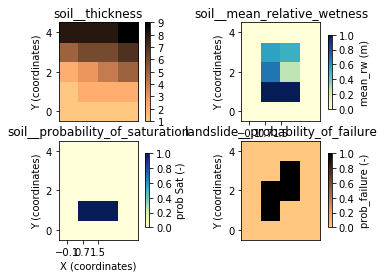

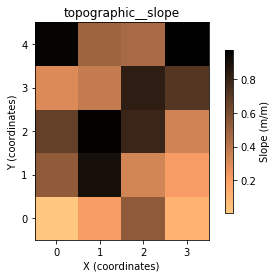

In [19]:
fig = plt.figure('Water Table Depth Calculations')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'soil__thickness', plot_name='soil (m)',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(222)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__mean_relative_wetness', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean_rw', var_units='m')

ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__probability_of_saturation', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='prob Sat', var_units='-')
ax4 = fig.add_subplot(224)
ax4.xaxis.set_visible(False)
imshow_grid_at_node(grid,'landslide__probability_of_failure', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='prob_failure', var_units='-')

plt.figure('Slope')
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
plt.savefig('Slope.png')


Save the arrays as variables by 'attaching the fields to the grid' and view the outputs. 

This simulation generates a probability value for each core node. 

In [20]:
LS_prob1_soil__probability_of_saturation = grid.at_node['soil__mean_relative_wetness']
grid.at_node['soil__mean_relative_wetness']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  0.69122789,
        0.26689438,  0.        ,  0.        ,  0.56824286,  0.52114178,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [21]:
LS_prob1_soil__probability_of_saturation = grid.at_node['soil__probability_of_saturation']
grid.at_node['soil__probability_of_saturation']

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
LS_prob1_soil__mean_watertable_depth = grid.at_node['soil__mean_watertable_depth']
grid.at_node['soil__mean_watertable_depth']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.95781606,  3.77418633,  0.        ,  0.        ,  3.60155298,
        2.93242247,  0.        ,  0.        ,  2.59054283,  2.87314933,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [23]:
LS_prob1_probability_of_failure = grid.at_node['landslide__probability_of_failure']
grid.at_node['landslide__probability_of_failure']

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])